# Measurement frequency experiments

In [1]:
%matplotlib inline

In [2]:
# Add path for pop_kernels package
import sys
sys.path.insert(0, "..")

In [3]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import qiskit as qk
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
import qiskit.tools.jupyter

from pop_kernels import SklearnIQDiscriminator
from sklearn.svm import SVC

%qiskit_job_watcher

qk.__qiskit_version__

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

{'qiskit-terra': '0.11.0',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.4.4',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.14.0'}

In [5]:
account_provider = qk.IBMQ.load_account()
# account_provider = qk.IBMQ.enable_account("XXX")
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project

In [6]:
# provider = qk.IBMQ.get_provider(hub="ibm-q-ncsu", group="reservations", project="csc591-001-592-0")
# provider = qk.IBMQ.get_provider(hub="ibm-q-ncsu", group="nc-state", project="csc-591-001-ece-")
# backend = provider.get_backend('ibmq_valencia')
provider = qk.IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_armonk')
config = backend.configuration()
defaults = backend.defaults()
device = pulse.PulseChannelSpec.from_backend(backend)

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [7]:
backend

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

In [11]:
num_qubits = config.n_qubits
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

In [9]:
# measurement frequency range for qubit 0 (GHz)
fr_0_range = config.meas_lo_range[0]
# centre of measurement frequency range for qubit 0 (GHz)
fr = sum(fr_0_range) / 2
# how far on either side of the centre frequency to search (in GHz)
fr_delta = 1 / 1e3
# frequency steps
fr_steps = np.linspace(fr - fr_delta, fr + fr_delta, 11)
# check frequency steps
assert all(fr_0_range[0] < x < fr_0_range[1] for x in fr_steps)

In [10]:
# Set to True to run experiments and save new results.
# If False, existing results are loaded.
run_experiments = False

In [12]:
qubits = [0]
schedules = []
meas_buffer = 2
shots = 512
experiment_name = 'measurement_freq_experiments'

In [13]:
meas = cmd_def.get('measure', qubits=tuple(range(num_qubits)))

# Create a calibration schedule for the ground state.
schedule_no_pi = pulse.Schedule(name='cal_0')
schedule_no_pi += meas

# Create a calibration schedule for the excited state.
schedule_pi = pulse.Schedule(name='cal_1')
for q in qubits:
    xgate = cmd_def.get('x', qubits=q)
    schedule_pi += xgate

schedule_pi += meas << (schedule_pi.duration + meas_buffer)

# Measurement schedule. Do an X90p gate on both qubits.
schedule_x90p = pulse.Schedule(name=experiment_name)
for q in qubits:
    x90p = cmd_def.get('u3', qubits=q, P0=np.pi/2., P1=0., P2=0.)
    schedule_x90p += x90p
    
schedule_x90p += meas << (schedule_x90p.duration + meas_buffer)
    
schedules = [schedule_no_pi, schedule_pi, schedule_x90p]

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: DeprecationWarning: The parameter "channels_to_plot" is being replaced by "channels"
  exec(code_obj, self.user_global_ns, self.user_ns)


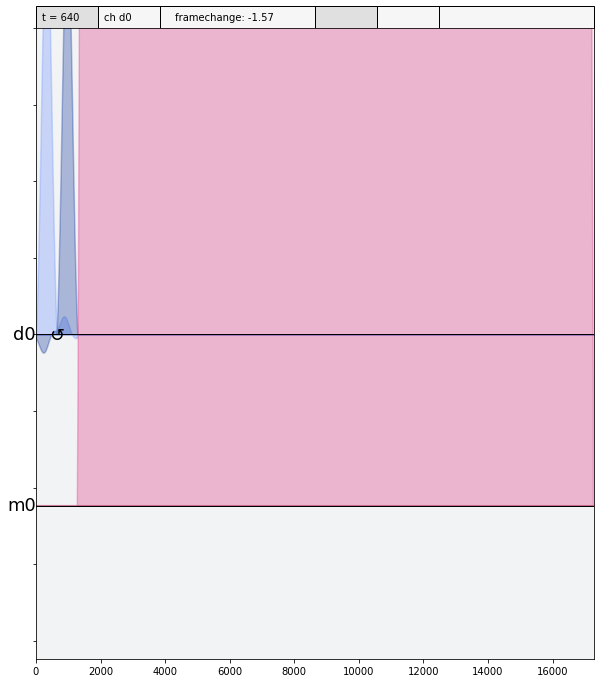

In [14]:
plt_chs = []
for q in range(num_qubits):
    plt_chs.append(device.qubits[q].measure)
    plt_chs.append(device.qubits[q].drive)

schedules[2].draw(channels_to_plot=plt_chs, scaling=10.)

In [15]:
def mk_qobj(fr):
    meas_lo_freq = [fr]
    qobj = qk.assemble(
        schedules, backend, meas_level=1, meas_return='single',
        meas_lo_freq=meas_lo_freq, shots=shots,
    )
    return qobj

In [16]:
def generate_new_data():
    results = []
    for fr in fr_steps:
        job = backend.run(mk_qobj(fr=defaults.meas_freq_est[0] / 1e9))
        job.status()
        result = job.result(timeout=3600)
        results.append({
            "measurement_frequency": fr,
            "result": result,
        })

    with open("ibmq_armonk_measurement_freq_experiment.pickle", "wb") as f:
        pickle.dump(results, f)
    
    return results
        
def load_existing_data():
    with open("ibmq_armonk_measurement_freq_experiment.pickle", "rb") as f:
        return pickle.load(f)
    
if run_experiments:
    all_results = generate_new_data()
else:
    all_results = load_existing_data()

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)
/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)
/home/simon/venvs/qiskit-pop-kernels/lib/pyt

In [17]:
discriminators = [
    SklearnIQDiscriminator(SVC(C=20.0, kernel="rbf"), result["result"], [q], ['0', '1'])
    for result in all_results
]

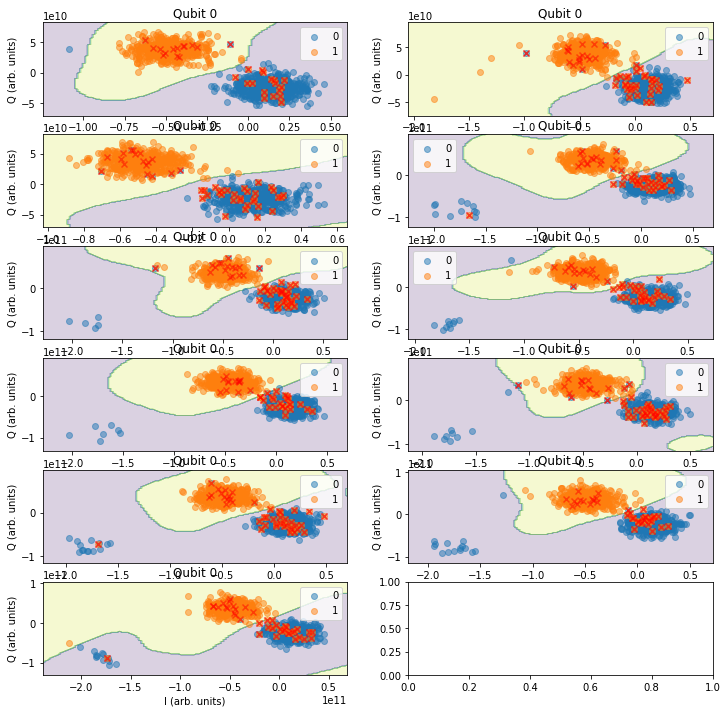

In [20]:
n_cols = 2
n_rows = int(np.ceil(len(discriminators) / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 12))
if n_rows == 1:
    ax = [ax]

for i, dscr in enumerate(discriminators):
    dscr.plot(ax[i // 2][i % 2], flag_misclassified=True, show_boundary=True)

In [21]:
def misclassifications(dscr):
    """ Return the list of misclassified IQ values. """
    x_data = np.array(dscr._xdata)
    y_data = np.array(dscr._ydata)
    y_disc = np.array(dscr.discriminate(dscr._xdata))
    misclassified = x_data[y_disc != y_data]
    return misclassified

In [22]:
df_errors = pd.DataFrame([
    {"meas_lo_freq": fr_step, "errors": len(misclassifications(d))}
    for fr_step, d in zip(fr_steps, discriminators)
])
df_errors.sort_values("meas_lo_freq", inplace=True)
df_errors

,meas_lo_freq,errors
0,6.992428,31
1,6.992628,48
2,6.992828,47
3,6.993028,44
4,6.993228,53
5,6.993428,42
6,6.993628,37
7,6.993828,49
8,6.994028,44
9,6.994228,38
